In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random, time
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# set to ignore warning
pd.set_option('mode.chained_assignment', None)

In [2]:
# load OU data
OU = pd.read_csv('../Data/NFL_OU_Data_Pre2020.csv')

In [3]:
# use OrdinalEncoder to transform team and opp to numeric value
ord_enc = OrdinalEncoder()
OU['team_code'] = ord_enc.fit_transform(OU[['team']])
OU.team_code = OU.team_code.astype(int)
OU['opp_code'] = ord_enc.fit_transform(OU[['opp']])
OU.opp_code = OU.opp_code.astype(int)
Codes = OU[['team', 'team_code', 'opp', 'opp_code']]

In [4]:
# drop 'Team' and 'Opp' since they are now encoded
OU.drop(['team', 'opp'], axis = 1, inplace = True)
OU.head()

,season,week,game,day,time,tm_off_bye,opp_off_bye,tm_btwn_gms,opp_btwn_gms,h_or_a,...,opp_winning_streak,opp_not_cover_streak,opp_cover_streak,opp_under_streak,opp_over_streak,spread,over/under,ou_result,team_code,opp_code
0,2010,2,2,0,0,0,0,7,7,1,...,1.0,0.0,1.0,1.0,0.0,13.0,43.0,0,3,11
1,2010,3,3,0,0,0,0,7,7,1,...,0.0,1.0,0.0,0.0,2.0,14.5,43.0,1,3,21
2,2010,4,4,0,0,0,0,7,7,0,...,2.0,0.0,2.0,0.0,2.0,6.0,37.0,1,3,24
3,2010,5,5,0,0,0,0,7,7,0,...,1.0,0.0,1.0,0.0,1.0,-2.5,41.5,1,3,14
4,2010,7,6,0,0,1,0,14,7,1,...,0.0,0.0,0.0,1.0,0.0,12.5,40.0,1,3,2


In [5]:
# seperate features and target
# X is feature matrix
X = OU.drop(['ou_result'], axis = 1)

# y is target
y = OU['ou_result']

In [6]:
# normalize data using StandardScaler
scaler = StandardScaler()
names = X.columns
d = scaler.fit_transform(X)
scaled_df = pd.DataFrame(d, columns = names)
scaled_df.head()

,season,week,game,day,time,tm_off_bye,opp_off_bye,tm_btwn_gms,opp_btwn_gms,h_or_a,...,opp_losing_streak,opp_winning_streak,opp_not_cover_streak,opp_cover_streak,opp_under_streak,opp_over_streak,spread,over/under,team_code,opp_code
0,-1.569228,-1.612611,-1.617026,-0.34067,-0.818153,-0.267775,-0.267775,-0.222248,-0.222248,1.0,...,-0.63908,-0.046277,-0.732048,0.115341,0.093121,-0.715697,2.059745,-0.455937,-1.356406,-0.488775
1,-1.569228,-1.400031,-1.385505,-0.34067,-0.818153,-0.267775,-0.267775,-0.222248,-0.222248,1.0,...,-0.06582,-0.658740,0.110830,-0.720261,-0.720917,0.856746,2.297408,-0.455937,-1.356406,0.595764
2,-1.569228,-1.187451,-1.153985,-0.34067,-0.818153,-0.267775,-0.267775,-0.222248,-0.222248,-1.0,...,-0.63908,0.566185,-0.732048,0.950942,-0.720917,0.856746,0.950652,-1.859594,-1.356406,0.921125
3,-1.569228,-0.974871,-0.922465,-0.34067,-0.818153,-0.267775,-0.267775,-0.222248,-0.222248,-1.0,...,-0.63908,-0.046277,-0.732048,0.115341,-0.720917,0.070524,-0.396105,-0.806851,-1.356406,-0.163413
4,-1.569228,-0.549711,-0.690945,-0.34067,-0.818153,3.734484,-0.267775,3.110071,-0.222248,1.0,...,-0.06582,-0.658740,-0.732048,-0.720261,0.093121,-0.715697,1.980524,-1.157765,-1.356406,-1.464860


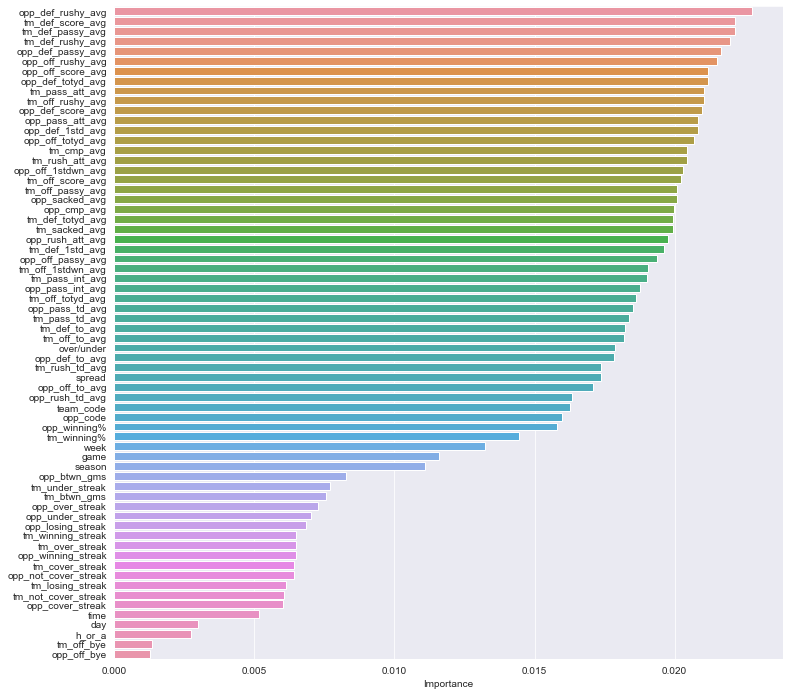

In [7]:
# visual of important features
clf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 50)

model = clf.fit(X,y)

feat_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns = ['Importance'])
feat_importances.sort_values(by = 'Importance', ascending = False, inplace = True)

sns.set_style('darkgrid')
plt.figure(figsize=(12,12))
sns.barplot(y = feat_importances.index, x = feat_importances.Importance)
plt.show()

In [8]:
# top features (all with importance of 0.015 or higher)
top_feat = []
for i in range(len(feat_importances)):
    if feat_importances['Importance'][i] > 0.015:
        top_feat.append(feat_importances['Importance'].index[i])
        
print(top_feat)

['opp_def_rushy_avg', 'tm_def_score_avg', 'tm_def_passy_avg', 'tm_def_rushy_avg', 'opp_def_passy_avg', 'opp_off_rushy_avg', 'opp_off_score_avg', 'opp_def_totyd_avg', 'tm_pass_att_avg', 'tm_off_rushy_avg', 'opp_def_score_avg', 'opp_pass_att_avg', 'opp_def_1std_avg', 'opp_off_totyd_avg', 'tm_cmp_avg', 'tm_rush_att_avg', 'opp_off_1stdwn_avg', 'tm_off_score_avg', 'tm_off_passy_avg', 'opp_sacked_avg', 'opp_cmp_avg', 'tm_def_totyd_avg', 'tm_sacked_avg', 'opp_rush_att_avg', 'tm_def_1std_avg', 'opp_off_passy_avg', 'tm_off_1stdwn_avg', 'tm_pass_int_avg', 'opp_pass_int_avg', 'tm_off_totyd_avg', 'opp_pass_td_avg', 'tm_pass_td_avg', 'tm_def_to_avg', 'tm_off_to_avg', 'over/under', 'opp_def_to_avg', 'tm_rush_td_avg', 'spread', 'opp_off_to_avg', 'opp_rush_td_avg', 'team_code', 'opp_code', 'opp_winning%']


In [9]:
corr = X.corr()
corr

,season,week,game,day,time,tm_off_bye,opp_off_bye,tm_btwn_gms,opp_btwn_gms,h_or_a,...,opp_losing_streak,opp_winning_streak,opp_not_cover_streak,opp_cover_streak,opp_under_streak,opp_over_streak,spread,over/under,team_code,opp_code
season,1.000000,-9.616594e-03,-0.004710,2.601908e-02,2.409085e-02,-0.000640,-0.000640,-0.003728,-0.003728,0.000000e+00,...,0.002301,0.012267,0.000850,0.005189,0.038861,-0.049669,0.000000e+00,1.336957e-01,0.000021,0.000021
week,-0.009617,1.000000e+00,0.997746,1.100355e-01,-1.331632e-02,-0.035686,-0.035686,-0.014716,-0.014716,-6.375991e-19,...,0.114155,0.101433,0.063156,0.063816,0.129752,0.045153,-1.762842e-17,-3.927947e-02,-0.000855,-0.000855
game,-0.004710,9.977459e-01,1.000000,1.107192e-01,-1.289764e-02,-0.063569,-0.041470,-0.035461,-0.019132,-9.772910e-04,...,0.112342,0.099886,0.063356,0.062626,0.127946,0.045578,8.632547e-04,-3.868743e-02,-0.001826,-0.000919
day,0.026019,1.100355e-01,0.110719,1.000000e+00,4.023183e-01,-0.070026,-0.070026,-0.333452,-0.333452,-1.031853e-17,...,-0.000680,0.029857,0.010252,-0.002393,0.014617,0.000653,4.423814e-18,5.389613e-03,0.010794,0.010794
time,0.024091,-1.331632e-02,-0.012898,4.023183e-01,1.000000e+00,-0.002962,-0.002962,-0.068727,-0.068727,1.286755e-18,...,-0.076652,0.085555,-0.013675,0.010286,-0.011942,-0.004430,2.001691e-18,1.258738e-01,0.052194,0.052194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
opp_over_streak,-0.049669,4.515284e-02,0.045578,6.531356e-04,-4.430029e-03,-0.014322,0.034824,-0.013870,0.039846,-1.045419e-02,...,-0.023991,0.028062,-0.010614,0.008366,-0.515958,1.000000,3.243091e-02,1.391047e-01,0.007151,0.024554
spread,0.000000,-1.762842e-17,0.000863,4.423814e-18,2.001691e-18,-0.013518,0.013518,-0.013372,0.013372,3.503246e-01,...,-0.280662,0.263603,-0.156124,0.141909,-0.017123,0.032431,1.000000e+00,4.080102e-17,-0.015149,0.015149
over/under,0.133696,-3.927947e-02,-0.038687,5.389613e-03,1.258738e-01,0.019997,0.019997,0.022177,0.022177,3.508366e-18,...,-0.099824,0.115498,-0.005902,0.043119,-0.145007,0.139105,4.080102e-17,1.000000e+00,0.021838,0.021838
team_code,0.000021,-8.551948e-04,-0.001826,1.079379e-02,5.219416e-02,0.000491,0.013775,-0.004347,0.020574,3.593765e-03,...,-0.001583,-0.002992,-0.001858,0.011216,-0.011261,0.007151,-1.514902e-02,2.183842e-02,1.000000,-0.072884


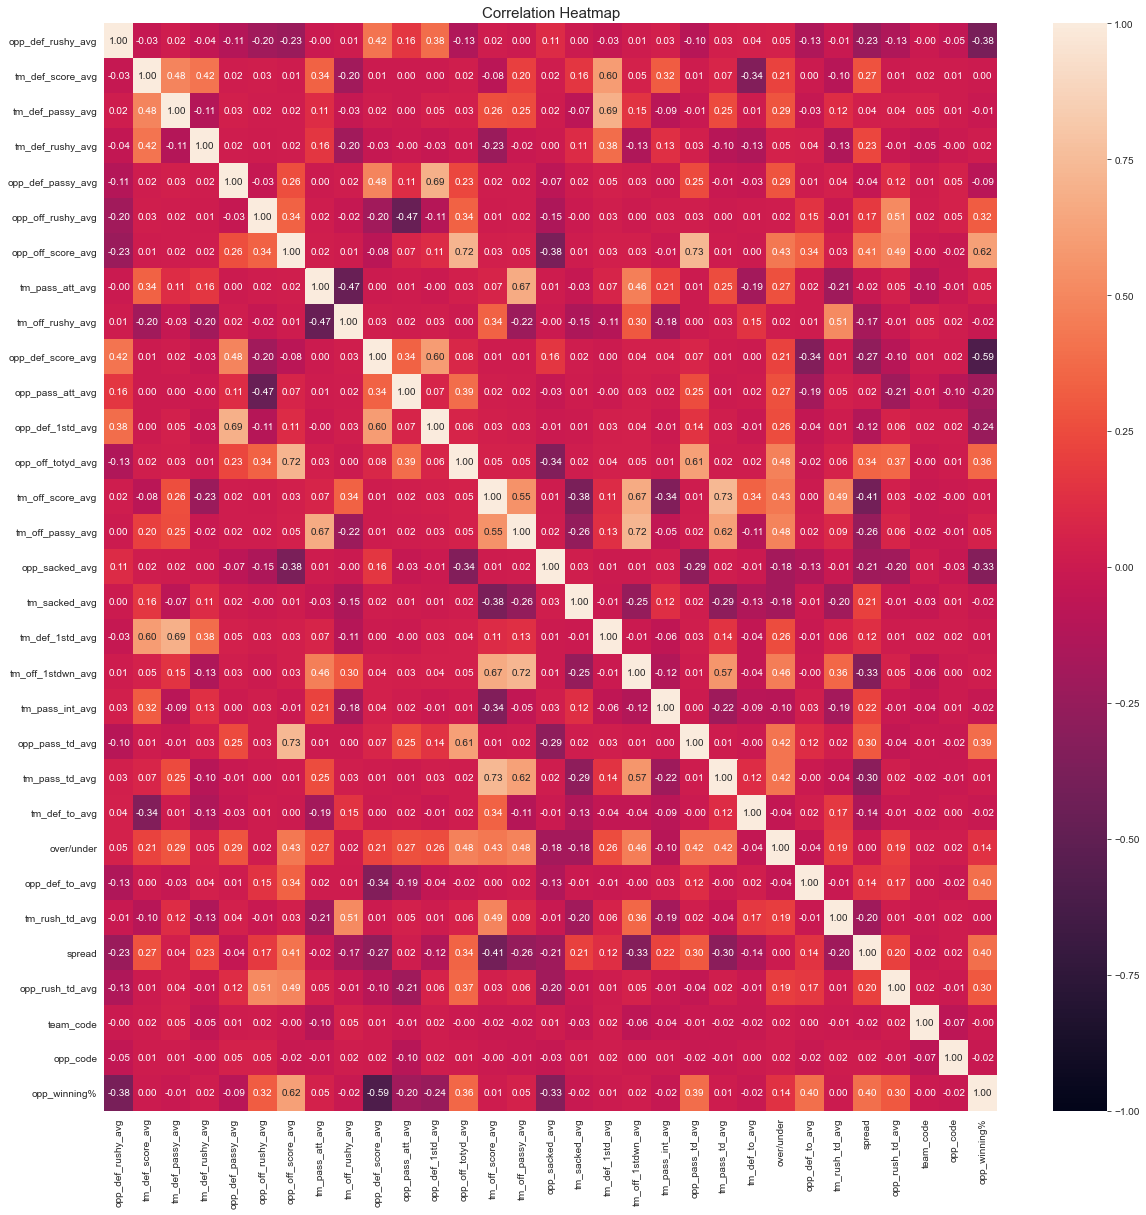

In [10]:
clean_up_more = X[['opp_def_rushy_avg', 'tm_def_score_avg', 'tm_def_passy_avg', 'tm_def_rushy_avg', 'opp_def_passy_avg',
                   'opp_off_rushy_avg', 'opp_off_score_avg', 'tm_pass_att_avg', 'tm_off_rushy_avg', 'opp_def_score_avg',
                   'opp_pass_att_avg', 'opp_def_1std_avg', 'opp_off_totyd_avg', 'tm_off_score_avg', 'tm_off_passy_avg',
                   'opp_sacked_avg', 'tm_sacked_avg', 'tm_def_1std_avg', 'tm_off_1stdwn_avg', 'tm_pass_int_avg',
                   'opp_pass_td_avg', 'tm_pass_td_avg', 'tm_def_to_avg', 'over/under', 'opp_def_to_avg', 
                   'tm_rush_td_avg', 'spread', 'opp_rush_td_avg', 'team_code', 'opp_code', 'opp_winning%']]
                  
clean_corr = clean_up_more.corr()
                  
# correlation heat map of new features
plt.figure(figsize = (20,20))
sns.heatmap(clean_corr, vmin = -1, vmax =1, annot = True, fmt = '.2f')
plt.title('Correlation Heatmap', fontdict = {'fontsize':15})
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

new_top_feat = clean_up_more.columns

In [11]:
# Set X as features data
X = scaled_df[new_top_feat]
X.head()

,opp_def_rushy_avg,tm_def_score_avg,tm_def_passy_avg,tm_def_rushy_avg,opp_def_passy_avg,opp_off_rushy_avg,opp_off_score_avg,tm_pass_att_avg,tm_off_rushy_avg,opp_def_score_avg,...,tm_pass_td_avg,tm_def_to_avg,over/under,opp_def_to_avg,tm_rush_td_avg,spread,opp_rush_td_avg,team_code,opp_code,opp_winning%
0,1.598146,-1.491300,-1.811043,0.906128,-1.641886,0.820819,0.773266,-0.232906,-2.200542,-0.522686,...,-0.912239,-2.320627,-0.455937,-0.772687,-1.795653,2.059745,0.545529,-1.356406,-0.488775,1.903565
1,0.071635,0.349066,-0.711523,0.071635,0.762558,-0.910937,0.594184,-1.887028,-0.837245,0.639650,...,-1.723891,-2.320627,-0.455937,-0.772687,-0.625062,2.297408,-1.795653,-1.356406,0.595764,0.002068
2,-1.956927,1.220818,-0.425568,1.272490,0.863247,0.845382,-0.002755,-1.749185,-0.259994,-1.362151,...,-0.912239,-1.804647,-1.859594,1.291232,-1.015259,0.950652,-1.015259,-1.356406,0.921125,0.637168
3,-0.355787,1.656694,-0.729647,2.615819,1.566053,0.728704,-0.883239,-1.731954,-0.155597,0.978664,...,-0.506413,-1.933642,-0.806851,0.388267,-1.210357,-0.396105,-0.625062,-1.356406,-0.163413,0.002068
4,-0.172606,1.840730,-0.941093,2.957757,-1.545225,0.065478,-0.719081,-1.597557,-0.122436,-1.329864,...,0.061743,-1.082275,-1.157765,-1.030677,-1.327417,1.980524,0.545529,-1.356406,-1.464860,0.637168


In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

# number of samples in each set
print('Samples in training set:', X_train.shape[0])
print('Samples in testing set:', X_test.shape[0])

Samples in training set: 3790
Samples in testing set: 948


In [13]:
# Evaluation of models using Confusion Matrix, Precision, Recall, F1 Score
# simple function for calculating and displaying metrics
def model_metrics(m):
    print('Train mean accuracy:', round(cross_val_score(m, X_train, y_train, cv = 10, scoring = 'accuracy').mean(), 4))
    print('Test mean accuracy:', round(cross_val_score(m, X_test, y_test, cv = 10, scoring = 'accuracy').mean(), 4))
    print('')
    print(classification_report(y_test, m.predict(X_test), zero_division = 0))
    cm = confusion_matrix(y_test, m.predict(X_test))
    plt.figure(figsize=(10, 5))
    heatmap = sns.heatmap(cm, annot = True, fmt = "d", annot_kws={"size": 20},
                cbar = False, cmap = 'Blues_r', 
                xticklabels = ['Under', 'Over'], yticklabels = ['Under', 'Over'])
    heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 15)
    heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 15, rotation = 0)
    plt.show()

In [14]:
# Random Forest
# Create the parameter grid
param_grid = {'bootstrap': [True], 'max_depth': [None], 'min_samples_leaf': [2, 3, 4, 5, 6], 
              'min_samples_split': [2, 4, 6], 'n_estimators': [100, 200, 300]}

# Create a based model
rf = RandomForestClassifier(random_state = 50)

# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1)
start_time = time.time()

grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.521900 using {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}
Execution time: 280.6598379611969 ms


Train mean accuracy: 0.5193
Test mean accuracy: 0.5168

              precision    recall  f1-score   support

           0       0.54      0.46      0.49       510
           1       0.46      0.54      0.50       438

    accuracy                           0.49       948
   macro avg       0.50      0.50      0.49       948
weighted avg       0.50      0.49      0.49       948



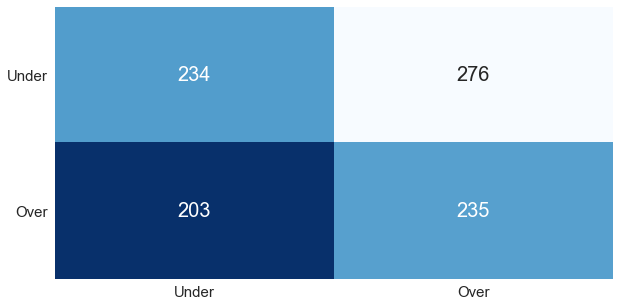

In [15]:
clf_rf_ou = RandomForestClassifier(bootstrap = True, max_depth = None,
                                min_samples_leaf =  2, min_samples_split =  6, n_estimators =  300)  
clr_rf_ou = clf_rf_ou.fit(X_train, y_train)
model_metrics(clr_rf_ou)

# dump the trained random forest classifier with Pickle
file = '..\\Pickles\\clf_rf_ou.pkl'

# open the file to save as pkl file
clf_rf_ou_pkl = open(file, 'wb')
pickle.dump(clf_rf_ou, clf_rf_ou_pkl)

# close the pickle instances
clf_rf_ou_pkl.close()

In [16]:
# Logistic Regression
# Create the parameter grid
param_grid = {'dual': [True,False], 'max_iter': [100, 200, 300, 500, 1000], 'C': [1.0, 1.5, 2.0, 2.5, 3.0]}

# Create a based model
lr = LogisticRegression(penalty = 'l2', random_state = 50)

# Instantiate the grid search model
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 10, n_jobs = -1)
start_time = time.time()

grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.502902 using {'C': 3.0, 'dual': False, 'max_iter': 100}
Execution time: 2.096289873123169 ms


Train mean accuracy: 0.5029
Test mean accuracy: 0.5231

              precision    recall  f1-score   support

           0       0.55      0.41      0.47       510
           1       0.47      0.61      0.53       438

    accuracy                           0.50       948
   macro avg       0.51      0.51      0.50       948
weighted avg       0.51      0.50      0.50       948



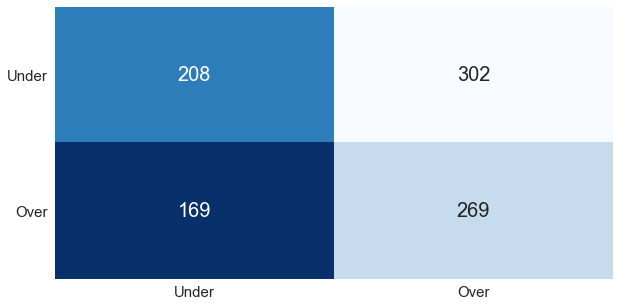

In [17]:
# Logistic Regression
clf_log_reg_ou = LogisticRegression(C = 3.0, dual = False, max_iter = 100)
clf_log_reg_ou = clf_log_reg_ou.fit(X_train, y_train)
model_metrics(clf_log_reg_ou)

# dump the trained logistic regression classifier with Pickle
file = '..\\Pickles\\clf_log_reg_ou.pkl'

# open the file to save as pkl file
clf_log_reg_ou_pkl = open(file, 'wb')
pickle.dump(clf_log_reg_ou, clf_log_reg_ou_pkl)

# close the pickle instances
clf_log_reg_ou_pkl.close()

Best k value is 81


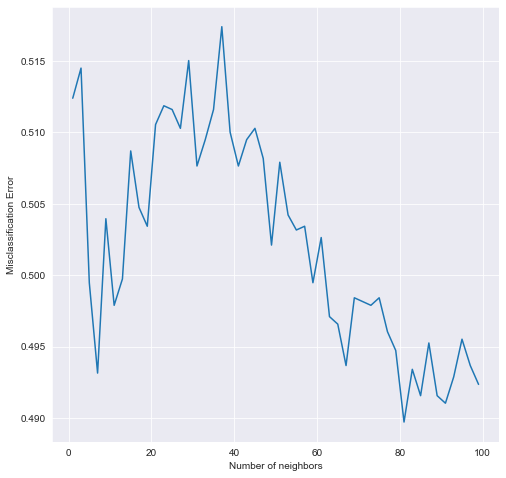

In [18]:
# K Nearest Neighbor
# Perform 10 fold cross validation
neighbors = []
cv_scores = []

for k in range(1, 100, 2):
    np.random.seed(20)
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_scores.append(scores.mean())

# Misclassification error versus k
MSE = [1-x for x in cv_scores]

# Determinethe best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('Best k value is', optimal_k)

# Plot misclassification error versus k
plt.figure(figsize=(8, 8))
sns.set_style('darkgrid')
plt.plot(neighbors, MSE)
plt.xlabel('Number of neighbors')
plt.ylabel('Misclassification Error')
plt.show()

Train mean accuracy: 0.5103
Test mean accuracy: 0.5138

              precision    recall  f1-score   support

           0       0.54      0.65      0.59       510
           1       0.46      0.36      0.40       438

    accuracy                           0.51       948
   macro avg       0.50      0.50      0.50       948
weighted avg       0.50      0.51      0.50       948



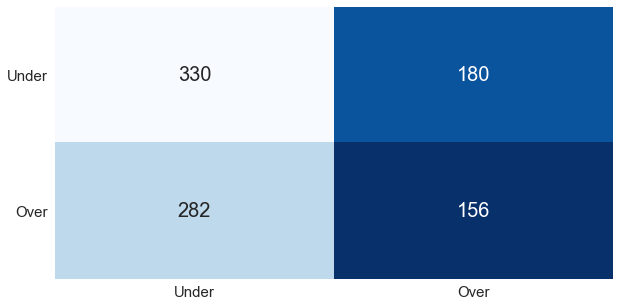

In [19]:
knn_ou = KNeighborsClassifier(n_neighbors = optimal_k)
knn_ou = knn_ou.fit(X_train, y_train)
model_metrics(knn_ou)

# dump the trained KNN classifier with Pickle
file = '..\\Pickles\\knn_ou.pkl'

# open the file to save as pkl file
knn_ou_pkl = open(file, 'wb')
pickle.dump(knn_ou, knn_ou_pkl)

# close the pickle instances
knn_ou_pkl.close()

Train mean accuracy: 0.5079
Test mean accuracy: 0.5273

              precision    recall  f1-score   support

           0       0.55      0.56      0.55       510
           1       0.47      0.47      0.47       438

    accuracy                           0.51       948
   macro avg       0.51      0.51      0.51       948
weighted avg       0.51      0.51      0.51       948



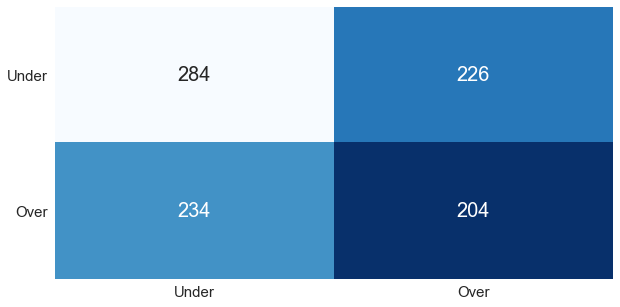

In [20]:
# Gaussian Classifier
clf_gnb_ou = GaussianNB()
clf_gnb_ou = clf_gnb_ou.fit(X_train, y_train)
model_metrics(clf_gnb_ou)

# dump the trained gaussian classifier with Pickle
file = '..\\Pickles\\clf_gnb_ou.pkl'

# open the file to save as pkl file
clf_gnb_ou_pkl = open(file, 'wb')
pickle.dump(clf_gnb_ou, clf_gnb_ou_pkl)

# close the pickle instances
clf_gnb_ou_pkl.close()